In [1]:
from time import strftime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import datetime 
import re
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from math import factorial
from scipy.signal import savgol_filter
from tabnanny import verbose
import numpy as np
import pandas as pd
import glob
import datetime 
from scipy import stats
from sklearn.linear_model import Lasso
import statsmodels.api as sm
pd.options.mode.chained_assignment = None
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

Defining Parameters

In [2]:
return_scale = 1
#Autocorrelation lags
lags = 45
lags_min = lags - lags
start_date = "2021-01-01"

## VIX Data

In [3]:
d1_name ="Data/VIX_History*"
d1_filename = glob.glob(d1_name)[0]
d1= pd.read_csv(d1_filename)
d1["RETURNS"] = d1["CLOSE"] - d1["CLOSE"].shift(return_scale)
d1['DATE'] = pd.to_datetime(d1["DATE"])
d1 = d1.set_index("DATE")
d1=d1.dropna()

In [4]:
d1_ret = d1[["RETURNS"]]

d1 = d1[["CLOSE"]]


## All User Data Processing

Downloading Data

In [5]:
partial_name = f'Data/Organic_Metaculus*'
filename = glob.glob(partial_name)[0]
df= pd.read_csv(filename, parse_dates=['Time'], index_col = ['Time'])
df= df[df['Users'] != 0]
X= df.index




Plotting New and Total Users over Time

Resampling data to daily cadence

In [6]:
df_daily = df.resample("1D").sum()
df_daily.index.rename("DATE", inplace= True)
df_daily=df_daily.loc[start_date:]
df_daily.head()

,Users,New Users
DATE,,
2021-01-01,1127,817
2021-01-02,1082,782
2021-01-03,1026,719
2021-01-04,1016,699
2021-01-05,1017,713


Calculating Returns

In [7]:
j = 0
for i in df_daily.columns:
    col_title = i + " Returns"
    df_daily[col_title] = df_daily.iloc[:,1 + j] - df_daily.iloc[:,1+ j].shift(return_scale)
    j += 1

df_daily = df_daily.dropna()
df_daily.head()

,Users,New Users,Users Returns,New Users Returns
DATE,,,,
2021-01-03,1026,719,-63.0,-28.0
2021-01-04,1016,699,-20.0,43.0
2021-01-05,1017,713,14.0,34.0
2021-01-06,2216,1861,1148.0,1134.0
2021-01-07,2018,1531,-330.0,-1478.0


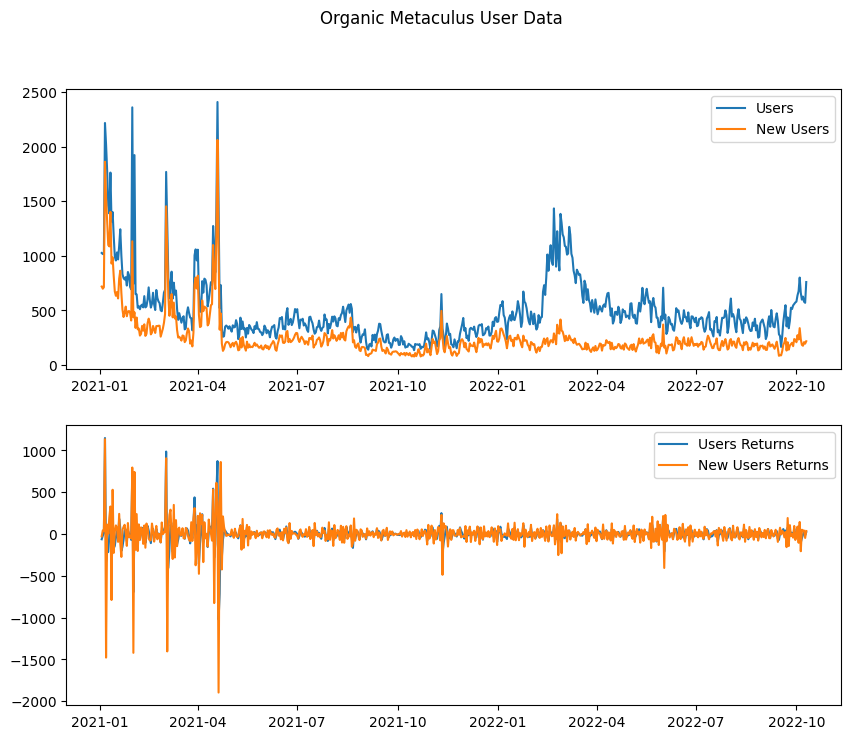

In [8]:
fig, axs = plt.subplots(2, figsize= (10, 8))

fig.suptitle("Organic Metaculus User Data")
for i in df_daily.columns:
    if "Returns" in i:
        axs[1].plot(df_daily.index,df_daily[i], label = i)
    else:
        axs[0].plot(df_daily.index,df_daily[i], label = i)

axs[1].legend()
axs[0].legend()

plt.show()


# Statistical Tests

In [9]:
daily_users = df_daily.iloc[:,:2]
daily_returns = df_daily.iloc[:,2:]

df_total = d1.merge(daily_users, on="DATE")
df_returns= d1_ret.merge(daily_returns, on="DATE")

df_list = [df_total, df_returns]

## Correlation Methods

#### Pearson Correlation

In [10]:
for i in df_list:
    cols = i.columns.to_list()
    corr_df = i.reset_index(drop=True).to_numpy()
    corr_coef = np.corrcoef(corr_df, rowvar = False)
    #print(corr_coef)
    for i in range(len(cols)):
        for j in range(i +1, len(cols)):
            print("{} vs {} Correlation: {}".format(cols[i], cols[j], corr_coef[i][j]))
    print("--------------")

CLOSE vs Users Correlation: 0.31008535824592204
CLOSE vs New Users Correlation: -0.00489763064796455
Users vs New Users Correlation: 0.826989717499613
--------------
RETURNS vs Users Returns Correlation: 0.1043624931100722
RETURNS vs New Users Returns Correlation: 0.0653093699713647
Users Returns vs New Users Returns Correlation: 0.7635373700050873
--------------


#### Spearman Correlation

In [11]:
for i in df_list:
    cols = i.columns.to_list()
    corr_df = i.reset_index(drop=True).to_numpy()
    corr_coef = stats.spearmanr(corr_df)[0]
    for i in range(len(cols)):
        for j in range(i +1, len(cols)):
            print("{} vs {} Correlation: {}".format(cols[i], cols[j], corr_coef[i][j]))
    print("--------------")

CLOSE vs Users Correlation: 0.4357624483156601
CLOSE vs New Users Correlation: 0.03745167943397286
Users vs New Users Correlation: 0.6968333174540359
--------------
RETURNS vs Users Returns Correlation: 0.12596625157472363
RETURNS vs New Users Returns Correlation: 0.09655099190362113
Users Returns vs New Users Returns Correlation: 0.7552449079582272
--------------


#### Cross Correlation

In [12]:
for i in df_list:
    cols = i.columns.to_list()
    
    for j in range(1,len(cols)):
        cross_corr = sm.tsa.stattools.ccf(i[cols[0]],i[cols[j]] )
        sorted_corr = sorted(np.abs(cross_corr), reverse = True) [0:5]
        print("{} vs. {}".format(cols[0], cols[j]))
        for k in sorted_corr:
            if k in cross_corr:
                print("Lag {}: {}".format(cross_corr.tolist().index(k), k))
            else:
                print("Lag {}: -{}".format(cross_corr.tolist().index(-k), k))
        print("")
        #print("{} vs {} Correlation: {}".format(cols[i], cols[j], corr_coef[i][j]))
    
    print("--------------")

CLOSE vs. Users
Lag 446: 6.249826899062535
Lag 445: 6.180981422534674
Lag 444: 5.962075383970519
Lag 447: 5.70104446759317
Lag 443: 5.565720887295611

CLOSE vs. New Users
Lag 446: 7.562285505635557
Lag 445: 7.34681735057002
Lag 444: 7.141884855782334
Lag 447: 7.133592217261478
Lag 443: 6.639648170684253

--------------
RETURNS vs. Users Returns
Lag 447: 1.4998617113273198
Lag 445: 1.30841407617125
Lag 439: -1.224632292187968
Lag 437: 1.1910571204003741
Lag 443: -0.9165883554600815

RETURNS vs. New Users Returns
Lag 444: -1.2641721601662936
Lag 439: -1.1409550207951733
Lag 447: 1.1023778110866693
Lag 438: 1.0532415850504462
Lag 440: 0.70679010160384

--------------


## Time Lagged LASSO Regression

In [13]:
for data in df_list:
    for j in data.columns:
        if j!= data.columns[0]:
            print("{} vs. {}".format(data.columns[0], j))
            lag_data = data[[data.columns[0], j]]
            for i in range(lags_min, lags):
                lag_name = "lag {}".format(i)
                lag_data[lag_name] = lag_data[j].shift(i)

            lag_data = lag_data.dropna()

            Y = lag_data[data.columns[0]]
            X = lag_data.iloc[:,1:]

            X_norm = X.copy()
            for i in X.columns:    
                X_norm[i] =(X[i] - X[i].mean()) / X[i].std() 

            Y_norm = (Y - Y.mean()) / Y.std() 


            alphas = np.geomspace(1e-3,1e-1, 20)
            for i in alphas:
                lassoreg = Lasso(alpha=i)
                lassoreg.fit(X_norm,Y_norm)
                coefs= lassoreg.coef_
                if sum(coefs) != 0:
                    alpha = i

            print("alpha: {}".format(alpha))
            lassoreg = Lasso(alpha=alpha)
            lassoreg.fit(X_norm,Y_norm)
            coefs= lassoreg.coef_


            lasso_df = X_norm.copy()
            drop_list = []
            for i in range(len(coefs)):
                if coefs[i] == 0:
                    drop_list.append(X_norm.columns[i])


            lasso_df = lasso_df.drop(columns = drop_list)

            lasso2 = sm.add_constant(lasso_df)
            sparse_reg = sm.OLS(Y, lasso2)
            sparse = sparse_reg.fit()
            print(sparse.summary())
            print("{} Statistically Significant Lags".format(sum(sparse.pvalues < 0.05)))

            print("-----------")


CLOSE vs. Users
alpha: 0.1
                            OLS Regression Results                            
Dep. Variable:                  CLOSE   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     14.73
Date:                Sat, 26 Nov 2022   Prob (F-statistic):           3.07e-11
Time:                        20:01:16   Log-Likelihood:                -1211.0
No. Observations:                 406   AIC:                             2432.
Df Residuals:                     401   BIC:                             2452.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2477    

## Granger Causality F-Tests

In [14]:
for data in df_list:
    x_col = data.columns[0]

    adf1 = sm.tsa.stattools.adfuller(data[x_col], autolag='AIC')[1]
    if adf1 >= 0.05:
        print("All {} Timeseries are not Stationary".format(x_col))
    else:
        for j in data.columns:
            if j!= x_col:
                adf2 = sm.tsa.stattools.adfuller(data[j], autolag='AIC')[1]

                if adf2 < 0.05:
                    granger = sm.tsa.stattools.grangercausalitytests(data[[x_col,j]], lags, verbose= False)
                    print( "{} vs. {}".format(x_col, j))
                else:
                    print("{} Timeseries are not Stationary".format(j))

                ftests=[]
                pvals = []
                for i in range(lags):
                    ftests.append(granger[i+1][0]['ssr_ftest'][0])
                    pvals.append(granger[i+1][0]['ssr_ftest'][1])

                sort_ftest = sorted(ftests,reverse = True) [0:5]

                for i in sort_ftest:
                    ind = ftests.index(i)
                    print("Lag {}: {}".format(ind +1, pvals[ind]))
                print("")
    print("----------")

CLOSE vs. Users
Lag 16: 0.14553692694691103
Lag 15: 0.1558478414822935
Lag 20: 0.14728899882116664
Lag 18: 0.15823305824611578
Lag 19: 0.19129931942767325

CLOSE vs. New Users
Lag 15: 0.03499670734013539
Lag 16: 0.03624210776317315
Lag 14: 0.09543860193655573
Lag 20: 0.08379827703746388
Lag 12: 0.13061748344034613

----------
RETURNS vs. Users Returns
Lag 15: 0.01863748839502331
Lag 14: 0.02408127953521101
Lag 16: 0.027390039805938588
Lag 11: 0.07040676018675583
Lag 13: 0.09043150396196997

RETURNS vs. New Users Returns
Lag 15: 0.010824786869391527
Lag 14: 0.012890922055681717
Lag 13: 0.01659835205535658
Lag 16: 0.013483383366364694
Lag 10: 0.04939519482746788

----------


## Dynamic Time Wrapping

In [15]:
for data in df_list:
    x_col = data.columns[0]

    dtw1 = (data[x_col] - data[x_col].mean())/data[x_col].std() 
    for j in data.columns:
        #print(j)
        if j!= x_col:
            dtw2 = (data[j] - data[j].mean())/data[j].std() 
            print( "{} vs. {}".format(x_col, j))

            distance, path = fastdtw( dtw1,dtw2, dist=euclidean)
            print("Distance: {}".format(distance))
            print("Average Distance: {}".format(distance/len(dtw2)))
            print("")
    print("----------")

CLOSE vs. Users
Distance: 214.4622813237869
Average Distance: 0.4765828473861931

CLOSE vs. New Users
Distance: 293.91518307385275
Average Distance: 0.6531448512752284

----------
RETURNS vs. Users Returns
Distance: 311.91780200282017
Average Distance: 0.6931506711173782

RETURNS vs. New Users Returns
Distance: 315.72024615997907
Average Distance: 0.7016005470221757

----------
